# Best Practices

As all API or software, Vertica ML Python has a cost. The user needs to understand Vertica and Vertica ML Python architectures to be really performant. We will go through the different ways to optimize the process. 

# 1. Optimize your architecture at the DataBase level

Do not forget that Vertica ML Python is an abstraction of SQL. Everything which will optimize Vertica performance will make Vertica ML Python more performant. The SQL code generation is automatic and there is nothing you can optimize from this side except following the next best practices. However most of the optimization resides on the Projections. Think in advance about your data architecture before creating a vDataFrame to select only the needed columns. In the following example, we use the 'usecols' parameter of the vDataFrame to only select the needed columns.

In [12]:
from vertica_ml_python import *
vdf = vDataFrame("public.titanic",
                 usecols = ["survived", "pclass", "age"])
print(vdf)

,pclass,age,survived
0,1,2.0,0
1,1,30.0,0
2,1,25.0,0
3,1,39.0,0
4,1,71.0,0
,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 3


# 2. Save the current relation when you can

vDataFrame works the same way a view is. If the final generated relation uses a lot of different functions, it will drastically increase the computation time needed at each method call. 

When the transformations are light they will not slow down the process whereas when the transformations are heavy (multiple joins, abusive usage of advanced analytical funcions or moving windows), it is highly advised to save the vDataFrame structure. Let's look at an example.

In [4]:
# Doing multiple operation
vdf["sex"].label_encode()["boat"].fillna(method = "0ifnull")["name"].str_extract(
    ' ([A-Za-z]+)\.').eval("family_size", expr = "parch + sibsp + 1").drop(
    columns = ["cabin", "body", "ticket", "home.dest"])["fare"].fill_outliers().fillna()
print(vdf.current_relation())

795 element(s) was/were filled
(
   SELECT
     "survived",
     "boat",
     "embarked",
     "sibsp",
     COALESCE("fare", 32.9113074018842) AS "fare",
     "sex",
     "pclass",
     "age",
     "name",
     "parch",
     "family_size" 
   FROM
 (
   SELECT
     "survived",
     DECODE("boat", NULL, 0, 1) AS "boat",
     COALESCE("embarked", 'S') AS "embarked",
     "sibsp",
     (CASE WHEN "fare" < -176.6204982585513 THEN -176.6204982585513 WHEN "fare" > 244.5480856064831 THEN 244.5480856064831 ELSE "fare" END) AS "fare",
     DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex",
     "pclass",
     COALESCE("age", 30.1524573721163) AS "age",
     REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name",
     "parch",
     parch + sibsp + 1 AS "family_size" 
   FROM
 (
   SELECT
     "survived",
     "boat",
     "embarked",
     "sibsp",
     "fare",
     "sex",
     "pclass",
     "age",
     "name",
     "parch" 
   FROM
 "public"."titanic") 
VERTICA_ML_PYTHON_SUBTABLE) 
VERTICA_ML_PYTHO

We can look at the explain plan of the new relation. It can help us to understand how Vertica will work when executing the different aggregations.

In [5]:
print(vdf.explain())

------------------------------ 
QUERY PLAN DESCRIPTION: 

EXPLAIN SELECT * FROM (SELECT "survived", "boat", "embarked", "sibsp", COALESCE("fare", 32.9113074018842) AS "fare", "sex", "pclass", "age", "name", "parch", "family_size" FROM (SELECT "survived", DECODE("boat", NULL, 0, 1) AS "boat", COALESCE("embarked", 'S') AS "embarked", "sibsp", (CASE WHEN "fare" < -176.6204982585513 THEN -176.6204982585513 WHEN "fare" > 244.5480856064831 THEN 244.5480856064831 ELSE "fare" END) AS "fare", DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex", "pclass", COALESCE("age", 30.1524573721163) AS "age", REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name", "parch", parch + sibsp + 1 AS "family_size" FROM (SELECT "survived", "boat", "embarked", "sibsp", "fare", "sex", "pclass", "age", "name", "parch" FROM "public"."titanic") VERTICA_ML_PYTHON_SUBTABLE) VERTICA_ML_PYTHON_SUBTABLE) VERTICA_ML_PYTHON_SUBTABLE

Access Path:
+-STORAGE ACCESS for titanic [Cost: 67, Rows: 1K (NO STATISTICS)] (PATH ID: 1)
|  Proje

We did plenty of operations and we must keep in mind that for each method call, this relation will be used to do the different computations. We can save the result as a table in the Vertica DataBase and use the parameter 'inplace' to change the current relation of the vDataFrame by the new one.

In [61]:
drop_table("public.titanic_clean")
vdf.to_db("public.titanic_clean",
              relation_type = "table",
              inplace = True)
print(vdf.current_relation())

The table public.titanic_clean was successfully dropped.
"public"."titanic_clean"


It is obvious that when we are dealing with huge volume of data, we must think twice before saving some transformations. That's why it is preferable to do an entire data exploration first and then do all the transformations when it is really needed. 

# 3. Use only the important columns

Vertica is a columnar MPP DataBase. That's why it is important to understand that most of the optimizations are made in the projections side. Vertica ML Python is not managing this part and it is important that the data you are exploring are well organized when dealing with huge volumes of data. Columnar DataBases are querying faster when less columns are used.

Most of the vDataFrame methods will automatically pick up all the numerical columns even if you have hundreds of them. That's why it is important to look at the functions parameters to pick up only what is needed. Let's look at an example.

In [82]:
vdf.sql_on_off()
vdf.avg()

,avg
"""fare""",33.9637936739659
"""body""",164.14406779661
"""pclass""",2.28444084278768
"""age""",30.1524573721163
"""parch""",0.378444084278768
"""survived""",0.364667747163695
"""sibsp""",0.504051863857374


<object>

As we did not use the parameter 'columns' to only focus the computation on what is needed, we computed the average of all the numerical columns of the vDataFrame. 

When dealing with small volume of data (less than Tb), it is not really important to care about it whereas when the volume is huge the performance will really depend on your data architecture. It is advised to pick up only the needed columns.

In [64]:
vdf.avg(columns = ["age", "survived"])

,avg
"""age""",30.1524573721163
"""survived""",0.364667747163695


<object>

If you just need to exclude some columns and to avoid writing all the needed columns name. It is possible to get a list of all the columns without specific ones using the 'get_columns' method.

In [83]:
titanic.get_columns()

['"fare"',
 '"sex"',
 '"body"',
 '"pclass"',
 '"age"',
 '"name"',
 '"cabin"',
 '"parch"',
 '"survived"',
 '"boat"',
 '"ticket"',
 '"embarked"',
 '"home.dest"',
 '"sibsp"']

In [84]:
titanic.get_columns(exclude_columns = ["boat", "embarked"])

['"fare"',
 '"sex"',
 '"body"',
 '"pclass"',
 '"age"',
 '"name"',
 '"cabin"',
 '"parch"',
 '"survived"',
 '"ticket"',
 '"home.dest"',
 '"sibsp"']

To get only numerical columns you can use the 'numcol' which is working the same way as 'get_columns'.

In [5]:
vdf.numcol()

['"fare"', '"body"', '"pclass"', '"age"', '"parch"', '"survived"', '"sibsp"']

In [6]:
vdf.numcol(exclude_columns = ["body", "sibsp"])

['"fare"', '"pclass"', '"age"', '"parch"', '"survived"']

For example, if you need to compute the correlation matrix of all the numerical columns except some of them. You can write the following code.

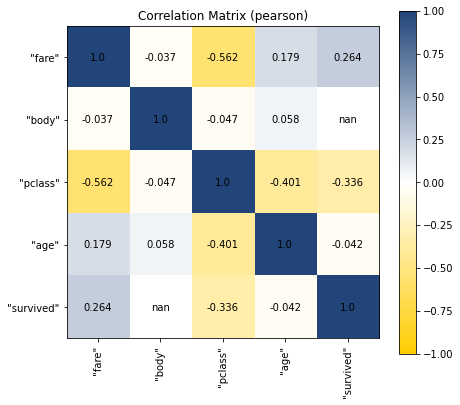

,"""fare""","""body""","""pclass""","""age""","""survived"""
"""fare""",1,-0.0372842548942878,-0.561687581153705,0.178575164117464,0.264150360783869
"""body""",-0.0372842548942878,1,-0.0472355333131433,0.0581765649177871,nan
"""pclass""",-0.561687581153705,-0.0472355333131433,1,-0.400828642351015,-0.335856950271864
"""age""",0.178575164117464,0.0581765649177871,-0.400828642351015,1,-0.0422446185581737
"""survived""",0.264150360783869,nan,-0.335856950271864,-0.0422446185581737,1


<object>

In [4]:
vdf.corr(columns = vdf.numcol(exclude_columns = ["parch", "sibsp"]))

# 4. Use the help function

The 'help' function is very useful when you want to know all the possible parameters.

In [65]:
help(vdf.agg)

Help on method agg in module vertica_ml_python.vdataframe:

agg(func:list, columns:list=[]) method of vertica_ml_python.vdataframe.vDataFrame instance
    ---------------------------------------------------------------------------
    Aggregates the vDataFrame using the input functions.
    
    Parameters
    ----------
    func: list
            List of the different aggregation.
                    approx_unique  : approximative cardinality
                    count          : number of non-missing elements
                    cvar           : conditional value at risk
                    dtype          : virtual column type
                    iqr            : interquartile range
                    kurtosis       : kurtosis
                    jb             : Jarque Bera index 
                    mad            : median absolute deviation
                    mae            : mean absolute error (deviation)
                    max            : maximum
                    mean    

# 5. Becareful when using DataBase cursors

The increase of DB connections will increase the concurrency on the system. So be sure to not let them open and to create them by yourself. Vertica ML Python simplifies the connection process by allowing the user to create an auto-connection. This option is not the best one and it is preferable to create your own cursor when you can. Let's create a DB connection.

In [67]:
import vertica_python

conn_info = {'host': "10.211.55.14", 
             'port': 5433, 
             'user': "dbadmin", 
             'password': "XxX", 
             'database': "testdb"}
conn = vertica_python.connect(** conn_info)
cur = conn.cursor()

We can use it to create a vDataFrame and do some operations.

In [68]:
vdf = vDataFrame("public.titanic", cur)
vdf["sex"].label_encode()["boat"].fillna(method = "0ifnull")["name"].str_extract(
    ' ([A-Za-z]+)\.').eval("family_size", expr = "parch + sibsp + 1").drop(
    columns = ["cabin", "body", "ticket", "home.dest"])["fare"].fill_outliers().fillna()

795 element(s) was/were filled


,survived,boat,embarked,sibsp,fare,sex,pclass,age,name,parch,family_size
0,0,0,S,1,151.5500000000000,0,1,2.0000000000000,Miss.,2,4
1,0,0,S,1,151.5500000000000,1,1,30.0000000000000,Mr.,2,4
2,0,0,S,1,151.5500000000000,0,1,25.0000000000000,Mrs.,2,4
3,0,0,S,0,0E-13,1,1,39.0000000000000,Mr.,0,1
4,0,0,C,0,49.5042000000000,1,1,71.0000000000000,Mr.,0,1
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 11

We can close the connection when we are done.

In [69]:
cur.close()
conn.close()

It is very important to follow the previous process when you are working in an environment with multiple users.

# 6. Understand the methods complexity

Some techniques are expensive in terms of computations. Using for example 'kendall' correlation is very expensive compared to 'pearson'. Due to the fact that 'kendall' correlation is using a cross join, its complexity is O(n*n) (n corresponding to the number of rows). Let's see it in a well known dataset.

In [73]:
vdf.time_on_off()
print("Pearson")
vdf.corr(method = "pearson", show = False)
print("Kendall")
vdf.corr(method = "kendall", show = False)

Pearson


Kendall


Kendall Correlation Matrix is much more time (around 100 times more than Pearson) to be computed because of its complexity.

# 7. Limit the number of elements to plot

Graphics are a powerful way to understand the data but they are used to summarize the information. Their purpose is not to draw millions of elements from which we could not extract information. Human mind likes when it is easy. Let's draw a multi-histogram where one of the column is categorical with thousand of categories.

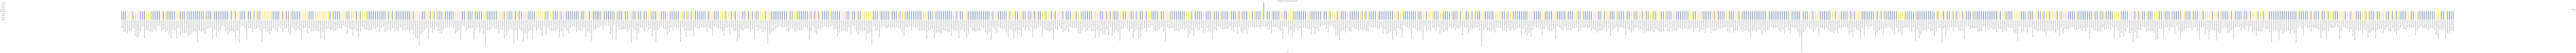

In [76]:
titanic.hist(["name", "survived"])

Vertica ML Python will try to draw it but it could take time if the dataset is huge and it could be totally useless whereas drawing graphics with few categories can give us much more information.

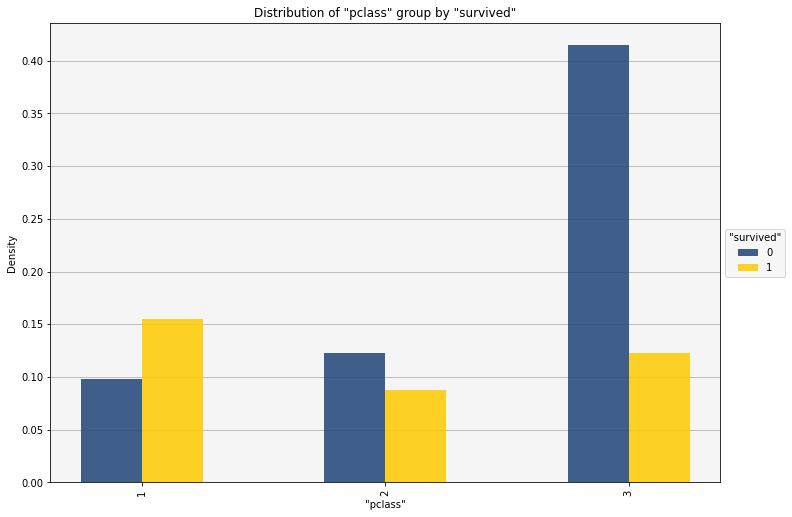

In [77]:
titanic.hist(["pclass", "survived"])

Try to always check your variables cardinality before drawing expensive graphics.

In [78]:
titanic.nunique()

,unique
"""fare""",277.0
"""sex""",2.0
"""body""",118.0
"""pclass""",3.0
"""age""",96.0
"""name""",1232.0
"""cabin""",182.0
"""parch""",8.0
"""survived""",2.0
"""boat""",26.0


<object>

# 8. Filter the data you don't need

Filtering should be the first action you do when preparing your data. It will drastically improve the performance of the process as you will avoid useless computation on elements you do not use later. In the following example, we decided to do a study on Titanic passengers who do not have access to a lifeboat.

In [79]:
vdf.filter("boat IS NOT NULL")

795 element(s) was/were filtered


,fare,sex,body,pclass,age,name,cabin,parch,survived,boat,ticket,embarked,home.dest,sibsp
0,75.2417,male,None,1,36.0,"Beattie, Mr. Thomson",C6,0,0,A,13050,C,"Winnipeg, MN",0
1,30.6958,male,None,1,None,"Hoyt, Mr. William Fisher",None,0,0,14,PC 17600,C,"New York, NY",0
2,211.3375,female,None,1,29.0,"Allen, Miss. Elisabeth Walton",B5,0,1,2,24160,S,"St Louis, MO",0
3,151.55,male,None,1,0.92,"Allison, Master. Hudson Trevor",C22 C26,2,1,11,113781,S,"Montreal, PQ / Chesterville, ON",1
4,26.55,male,None,1,48.0,"Anderson, Mr. Harry",E12,0,1,3,19952,S,"New York, NY",0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 439, Number of columns: 14

It is not needed to think this way when we are dealing with small volumes of data but it is really important to think about filtering useless information first when dealing with huge volumes of data.

# 9. Filter the columns you don't need

As explained before, using only the needed columns in the different methods is one the keys to increase performance. To avoid, writing more codes to exclude useless column it is possible to filter them using the 'drop' method.

In [7]:
vdf.drop(["name", "boat"])

,survived,ticket,embarked,home.dest,sibsp,fare,sex,body,pclass,age,cabin,parch
0,0,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,female,None,1,2.0,C22 C26,2
1,0,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,male,135,1,30.0,C22 C26,2
2,0,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,female,None,1,25.0,C22 C26,2
3,0,112050,S,"Belfast, NI",0,0.0,male,None,1,39.0,A36,0
4,0,PC 17609,C,"Montevideo, Uruguay",0,49.5042,male,22,1,71.0,None,0
,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 12

By using the 'drop' method, Vertica ML Python will simply not use the input columns in the next SQL code generation.

In [8]:
print(vdf.current_relation())

(
   SELECT
     "survived",
     "ticket",
     "embarked",
     "home.dest",
     "sibsp",
     "fare",
     "sex",
     "body",
     "pclass",
     "age",
     "cabin",
     "parch" 
   FROM
 "public"."titanic") 
VERTICA_ML_PYTHON_SUBTABLE


# 10. Enjoy :p

Even in your own personal machine you can now deal with volume of data you could not in the past. Learn how to optimize your Vertica DB and start playing with Vertica ML Python. The next lesson will teach you how to ingest your first datasets.